In [1]:
#Impoort all Packages in this part
import numpy as np   #TO use for nd arrays
import os
import pandas as pd
import scipy.ndimage
%matplotlib inline
import matplotlib.pyplot as plt
import cv2    #To draw Contours
import math
import dicom   # Only package to load dicom images
from sklearn.cluster import KMeans #for KMeans clustering we need 2 clusters here
from skimage import measure, morphology   #skimage is used for drawing contours
from mpl_toolkits.mplot3d.art3d import Poly3DCollection   #using this occassionally to see the 3d version of the images
import skimage
import tensorflow as tf
print(skimage.__version__)


/home/sdash/.local/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


0.13.0


In [2]:
# Here we basically try to extract all the patients.
#the patient images are stored as folder names as patientIDs
DATA_PATH = "/scratch2/sdash/data/stage1"
allPatients = os.listdir(DATA_PATH)
allPatients.sort()

labels_df = pd.read_csv('/scratch2/sdash/data/stage1_labels.csv', index_col=0)

labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [50]:
#extract the labelled patients which has a label in the labels_df file
patients = []
unlabeledpatientID = []
unlabeled = 0
for num,patient in enumerate(allPatients):
    try:
        haslabel = labels_df.get_value(patient,'cancer')
        patients.append(patient)
        
    except:
        #print(patient+" is unlabelled")
        unlabeledpatientID.append(patient)

print("labelled patients",len(patients))
print("ALL Patients",len(allPatients))
print("Unlabelled patients",len(unlabeledpatientID))
unlabeledpatientID[1]

('labelled patients', 1397)
('ALL Patients', 1595)
('Unlabelled patients', 198)


'031b7ec4fe96a3b035a8196264a8c8c3'

In [4]:
#Visualizatioon: seeing the raw dicom data
path = DATA_PATH + '/' + patients[0]
slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))     #Imageposition Patient tells about the position of the slice
#print((slices[1].pixel_array))
print(slices[0])
    

(0008, 0000) Group Length                        UL: 358
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.321555830121981826540353244716
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0000) Group Length                        UL: 64
(0010, 0010) Patient's Name                      PN: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0020) Patient ID                          LO: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 0000) Group Length                        UL: 390
(0020, 000d) Study Instance UID                  UI: 2.25.51820907428519808061667399603379702974102486079290552633235
(0020, 000e) Series Instance UID           

In [5]:
#making a function to visualize the histogram plot of the pixels given to it
def histogram(pixels):
    plt.hist(pixels.flatten(), bins=50, color='c')
    plt.xlabel("Hounsfield Units(HU)")
    plt.ylabel("Frequency")
    plt.show()

In [6]:
#Making this function which we will use to see the images of each slice of ithe number patient
IMG_PX_SIZE = 150

def SeeData(i):
    for patient in patients[:i]:
        label = labels_df.get_value(patient, 'cancer')
        path = DATA_PATH + '/' + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
        #uncomment below code when we need to visualize the labels also
        #print(label)
        #plt.imshow(slices[0].pixel_array,cmap='gray')
    
        fig = plt.figure()
        for num,each_slice in enumerate(slices[:12]):
            y = fig.add_subplot(3,4,num+1)
            new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
            y.imshow(new_img)
        plt.show()
    

In [7]:
def load_scan(path):
    print("loading from ", path)
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    #print(len(slices))
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        #subtracting adjacent slices to knoe the thickness
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness #we are changing the slicethickness 
        
    return slices


In [8]:
def get_pixels_hu(slices):
    #this function will stack or stitch the 2D images to form a 3D image
    Image3d = np.stack([s.pixel_array for s in slices])
    
    #Converting the pixels to a value of 16-bit int values
    Image3d = Image3d.astype(np.int16)
        
    # Black Corner Porblem: -2000 is by default set in the edges of the images where the cylindrical 
    # The intercept is usually -1024, so pixel_value of air is 0
    Image3d[Image3d == -2000] = 0
    #print(Image3d[0])
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):   
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        #print(intercept,slope)
        if slope != 1:
            Image3d[slice_number] = slope * Image3d[slice_number].astype(np.float64)
            Image3d[slice_number] = Image3d[slice_number].astype(np.int16)
            
        Image3d[slice_number] = Image3d[slice_number] + np.int16(intercept)
    
    return np.array(Image3d, dtype=np.int16)


In [9]:
#this adjusts the images pixels to make the stack of equal space
def samplingToEvenSpacing(image, allscans, new_spacing=[1,1,1]):
    
    spacing = map(float, ([allscans[0].SliceThickness] + allscans[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [10]:
def patient_pixel(i):
    AllSlices = load_scan(DATA_PATH + '/' + patients[i])
    patient = patients[i]
    #print(AllSlices[0].SliceThickness)
    patient_pixels_3d = get_pixels_hu(AllSlices)
    
    patient_pixels_3d,_ = samplingToEvenSpacing(patient_pixels_3d, AllSlices, [1,1,1])
    
    #print(patients[i]) #patient ID
    
    # uncomment: To see some slices in between
    #plt.imshow(patient_pixels_3d[70],cmap='gray')
    #plt.show()
    
    return patient, patient_pixels_3d


('loading from ', '/scratch2/sdash/data/stage1/0030a160d58723ff36d73f41b170ec21')
(298, 298)
0030a160d58723ff36d73f41b170ec21


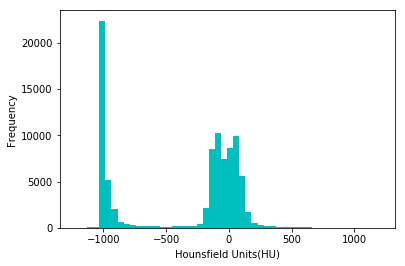

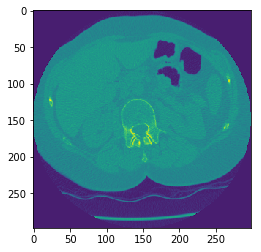

In [13]:
patientID,Patient3D = patient_pixel(1)
print(Patient3D[1].shape)
print(patientID)
histogram(Patient3D[1])
plt.imshow(Patient3D[1])

In [24]:
#trying to 3D View the image: credits to some of the tutorial kernel in Kaggle for thiis logic.

def make_mesh(image, threshold=-300, step_size=1):
    
    p = image.transpose(2,1,0)
    
    print("Calculating triangles to build the 3D")
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    #verts, faces = measure.marching_cubes(p, threshold)
    
    return verts, faces

def plot_3d(verts, faces):
    
    print "Drawing"
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [0, 0, 0]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    plt.show()

('loading from ', '/scratch2/sdash/data/stage1/0030a160d58723ff36d73f41b170ec21')
Calculating triangles to build the 3D
Drawing


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


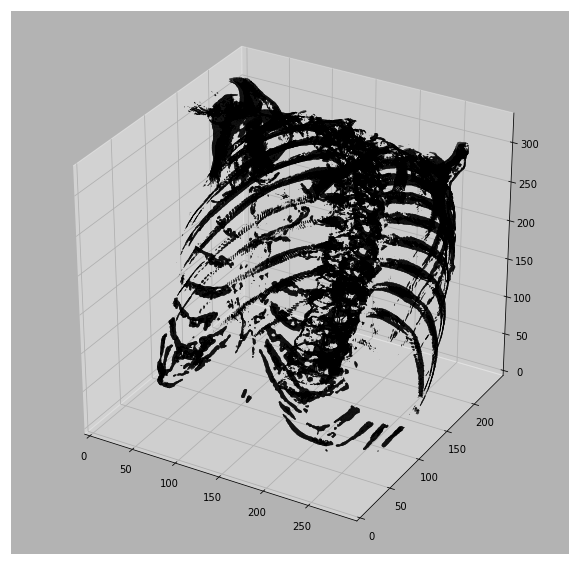

In [25]:
patientID,Patient3D = patient_pixel(1)
vs,fs = make_mesh(Patient3D,500)
plot_3d(vs,fs)

('loading from ', '/scratch2/sdash/data/stage1/008464bb8521d09a42985dd8add3d0d2')
292
Lungmask
(370, 370)
int64


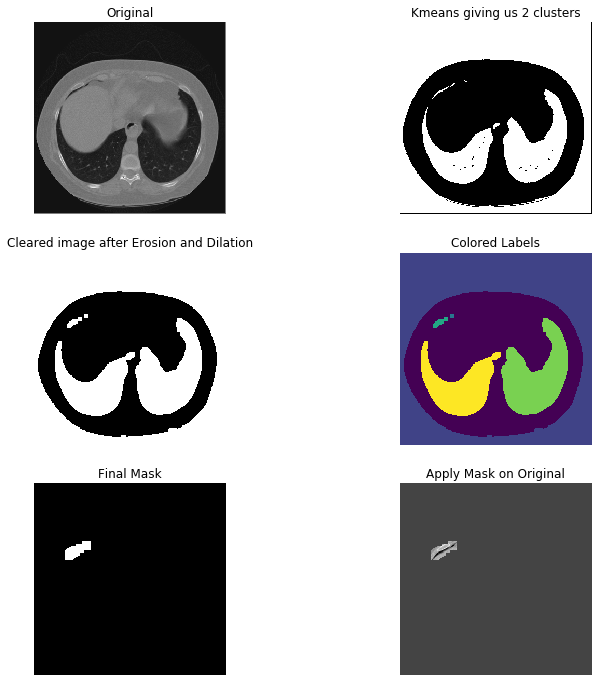

In [34]:
#using K-means and erosion, dilation and morphology tools of opencv
# we are trying to segment the lungs data to a small set of pixels to make the  3D small in size
# a nice small sized 3D image may give us better results in tensorflow

def lungmask(patientImg, display=False):
    print("Lungmask")
    row_size= patientImg.shape[0]
    col_size = patientImg.shape[1]
    print(row_size,col_size)
    #normalization of the pixel data using Standard Deviation
    mean = np.mean(patientImg)
    std = np.std(patientImg)
    patientImg = patientImg-mean
    patientImg = patientImg/std
  
    #Starting with the middle of the image as one cluster for the initial value to K-means
    middleArea = patientImg[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middleArea)  
    max = np.max(patientImg)
    min = np.min(patientImg)
  
    #Limiting the value the pixels for uniformity
    patientImg[patientImg==max]=mean
    patientImg[patientImg==min]=mean
    #
    # Using Kmeans to separate soft-tissue/bone(majorly inside the lungs) and lung/air(outside Lungs)
    #
    mask = 1
    try:
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middleArea,[np.prod(middleArea.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(patientImg<threshold,1.0,0.0)  # thresholding the image to 1 and 0 values only

        # Doing Erosion and dilation to remove the small structures from the lungs 

        eroded = morphology.erosion(thresh_img,np.ones([3,3]))
        dilation = morphology.dilation(eroded,np.ones([8,8]))
    
        # Different labels are displayed in different colors
        labels = measure.label(dilation)
        #nlabels = scipy.ndimage.measurements.label(dilation)  #For older version of skimage
    
    
        #labels = nlabels[0].astype(np.uint8)
        print(labels.dtype)
        label_vals = np.unique(labels)
        regions = measure.regionprops(labels)
        good_labels = []
        for prop in regions:
            B = prop.bbox
            if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
                good_labels.append(prop.label)
        mask = np.ndarray([row_size,col_size],dtype=np.uint8)
        mask[:] = 0
        #print(mask.dtype)

        #
        #  we do another large dilation in order to fill in and out the lung mask 
        #
        for N in good_labels:
            mask = mask + np.uint8(np.where(labels==N,1,0))

        #print(mask.dtype)
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

        #To see the results
        if (display):
            fig, ax = plt.subplots(3, 2, figsize=[12, 12])
            ax[0, 0].set_title("Original")
            ax[0, 0].imshow(patientImg, cmap='gray')
            ax[0, 0].axis('off')
            ax[0, 1].set_title("Kmeans giving us 2 clusters")
            ax[0, 1].imshow(thresh_img, cmap='gray')
            ax[0, 1].axis('off')
            ax[1, 0].set_title("Cleared image after Erosion and Dilation")
            ax[1, 0].imshow(dilation, cmap='gray')
            ax[1, 0].axis('off')
            ax[1, 1].set_title("Colored Labels") #We don't need this much
            ax[1, 1].imshow(labels)
            ax[1, 1].axis('off')
            ax[2, 0].set_title("Final Mask")
            ax[2, 0].imshow(mask, cmap='gray')
            ax[2, 0].axis('off')
            ax[2, 1].set_title("Apply Mask on Original")
            ax[2, 1].imshow(mask*patientImg, cmap='gray')
            ax[2, 1].axis('off')

            plt.show()
            
    except:
        pass 
    
    return mask*patientImg

patientID,Patient3D = patient_pixel(4)
print(len(Patient3D))
maskedImage = lungmask(Patient3D[70],True)

In [35]:
#Now here we are making stacks or chunks of slices to make 3D Images of the mask applied image.
def chunks(l, n):
    #print(int(n))
    try:
        for i in xrange(0, len(l), int(n)): yield l[i:i + int(n)]
    except:
        pass
        
def mean(l):
    return sum(l) / len(l)


#TO save 130 GB of data we divided the data into 4 Big blocks of data of 250 patients each to finish 
#our work at less amount of time
def SaveData():
    TFData = []
    print("Started")
    for i,ithPatient in enumerate(patients[751:len(patients)]):
        
        patientID,Patient3DPixels = patient_pixel(i)
        Stage1label = labels_df.get_value(patientID,'cancer')
        if( i==2):
            print("1 Pass successful")
        if (i%50 == 0):
            print(patientID)
            print(len(Patient3DPixels),i)
            
        #making a onehotLabel format labels to deal with 
        if Stage1label == 1: 
            oneHotlabel=np.array([0,1])
        elif Stage1label == 0: 
            oneHotlabel=np.array([1,0])
        
        #print(Stage1label) #just a log to see that the progress is happenning
        maskedImage3D = []
        for j,scan in enumerate(Patient3DPixels):
            maskedImage = lungmask(scan,False)
            maskedImage3D.append(maskedImage)
        
        #making new slices of 64 x 64 x 32 sized 3D Images
        new_slices = []
        img_px_size = 64
        hm_slices = 32
        #Resizing to smaller images
        slices = [cv2.resize(np.array(each_slice),(img_px_size,img_px_size)) for each_slice in maskedImage3D]
    
        chunk_sizes = math.ceil(len(slices) / hm_slices)
        for slice_chunk in list(chunks(slices, chunk_sizes)):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        # Binning by Boundary is needed
        #len(new_slices is less than hm_slices)
        if( len(new_slices) < hm_slices ):
            for i in range(len(new_slices),hm_slices):
                new_slices.append(new_slices[len(new_slices)])
        elif(len(new_slices) > hm_slices):
            #print("length =")
            #print(len(new_slices))
            new_slices = new_slices[0:hm_slices]
        
        #plt.imshow(maskedImage3D[0])
        TFData.append([new_slices,oneHotlabel,patientID])
        
    np.save("TensorflowData3.npy",TFData)
    print("Save Data Completed ")
    
#Save the  data in disc
#SaveData()

200
('labels = ', array([0, 1]))
('PatientID = ', '0015ceb851d7251b8f399e39779d1e7d')


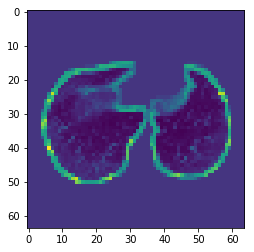

In [47]:
#Visualizing the npy array that is stored 
LoadData = np.load("TensorflowData.npy")
print(len(LoadData))
print("labels = ",LoadData[0][1])
print("PatientID = ",LoadData[0][2])
plt.imshow(LoadData[0][0][10])  #if image appears we are good
#vs,fs = make_mesh(LoadData[0][0],350)
#plot_3d(vs,fs)